<a href="https://colab.research.google.com/github/Mohamad-Atif1/paper2code/blob/main/Meta_learning/MAML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Meta learning background**

Meta-learning, also known as “learning to learn,” is a subfield of machine learning that aims to develop models capable of quickly adapting to new tasks using only a small amount of data. The main idea is to train models that can generalize knowledge from previously seen tasks, enabling fast learning on unseen but related tasks.

In typical supervised machine learning problems, we aim to create a model that performs well on a single task, so we train the model on that task and evaluate it on the same task. In contrast, meta-learning aims to train a model that can quickly adapt to many new tasks, so we train the model on a set of tasks and test it on entirely new, unseen tasks! Usually, you would only need to pass a few examples like 5 to 15.

In the following sections, we will explore how to train such models by implementing [MAML (Model-Agnostic Meta-Learning)](https://arxiv.org/abs/1703.03400). But before that, let’s clarify some important terminology


## **Terminology**
In supervised machine learning, we have a **dataset**  $𝒟 =\{(x,y)_k\}$ which is a set of pairs of inputs and outputs (i.e., features and labels). We aim to minimize the loss which is typically the negative log likelihood $ \operatorname{argmin} _θ ℒ(θ,𝒟)$

In meta-learning, we have a multiple tasks that are sampled from a **task distribution** $p(𝛵)$. Task is a dataset with its loss $𝛵 = \{𝒟,ℒ\}  $. Typically, each task is divided into a support set $𝒟^{tr}$ (used for adaptation) and a query set $𝒟^{test}$ (used for evaluation). In the few-shot setting, this is often described as N-way K-shot: each task is an N-class classification problem with K labeled examples per class in the support set, where both the features and their labels are used to adapt the model to the task . The query set contains additional labeled examples from those N classes; during evaluation, the model receives only the query features, and the labels are used to measure performance after adaptation. Formally, predictions are made as
$$
y^{ts} = f_θ(𝒟^{tr},x^{ts})
$$

The goal is to find a learning algorithm $ϕ$ (sometimes called meta-learner or meta-parameters) that is used to find the optimal parameters $θ^*$ on unseen tasks.

All terms are described in the Figure below

<img src="https://github.com/Mohamad-Atif1/paper2code/blob/main/Meta_learning/images/Terminology.png?raw=true">

*This figure is taken from [Chelsea B. Finn dissertation](https://ai.stanford.edu/~cbfinn/_files/dissertation.pdf#page=13.14)*



---



# Model Agnostic Meta Learning

Model-Agnostic Meta-Learning (MAML) is an optimization-based method for few-shot learning. MAML focuses on the training process itself not on the model architecture; thats why it is called “model-agnostic” because it does not depend on any specific model architecture, it works with any model that can be trained using gradient descent. This flexibility makes MAML broadly applicable to many types of problems.



## MAML algorithm

1: Initialize Meta-Parameters $ϕ$

2: Randomly select a batch of tasks from the task distribution.

3: For each sampled task ($θ$ update):

* Make a copy of the meta-parameters $ϕ$ (let’s call them $θ$), initially $ϕ = θ$


* Use the support set $𝒟^{tr}$ from the current task to compute the loss with $θ$

* Perform a few steps of gradient descent on $θ$ to get new parameters $θ^*$.

$$
θ^* = θ - α ∇_θℒ(𝒟^{tr},θ)
$$
   
*   The final $θ$ is $θ^*$


4: Meta-Update ($\phi$ Update):

The loss function for meta is the average loss of all tasks using $θ^*$

$$
 ℒ_{meta} = \mathbb{E}_{𝛵 \sim p(𝛵)} \left[
    ℒ_{𝛵}\left(θ^*,𝒟^{test}
    \right)
\right
]
$$

and we update

$$
ϕ = ϕ - β ∇_ϕ ℒ_{meta}(𝒟^{tr},𝒟^{test},ϕ)
$$


5: Go back to Step 2 and repeat for many iterations.


Notice that a meta-update step requires  higher-order gradients (gradient through a gradient step) since we have two updates: $θ^*$ and $ϕ$. This makes the computation quite expensive.
One of the suggested solutions is to treat the inner update $θ^*$ as a constant for the outer update $ϕ$ to avoid higher-order derivatives. This approach is known as FOMAML. For more details, see [First-Order MAML](https://arxiv.org/abs/1803.02999)



In this notebook, we will apply the original MAML algorithm on omniglot dataset


# Coding part


In [1]:
!pip install higher

  Attempting uninstall: nvidia-cusolver-cu12
    Found existing installation: nvidia-cusolver-cu12 11.6.3.83
    Uninstalling nvidia-cusolver-cu12-11.6.3.83:
      Successfully uninstalled nvidia-cusolver-cu12-11.6.3.83


## Dataset

Omniglot dataset:


it is a dataset of handwritten characters from many different alphabets (like Latin, Greek, Hindi, etc.).
It was designed for few-shot learning — each character has only 20 examples, written by different people.
In total, it has 1,623 different characters from 50 alphabits

In [2]:
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import functional as TF

train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),
    transforms.Lambda(lambda x: TF.rotate(x, random.choice([0, 90, 180, 270]))),
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
])

# Load the Omniglot dataset
background_dataset = torchvision.datasets.Omniglot(
    root='./', download=True,transform=train_transform, background=True
)
evaluation_dataset = torchvision.datasets.Omniglot(
    root='./', download=True, transform=test_transform, background=False
)

print(f"Number of background classes: {len(background_dataset._alphabets)}")
print(f"Number of evaluation classes: {len(evaluation_dataset._alphabets)}")
print(f"Number of images in background dataset: {len(background_dataset)}")
print(f"Number of images in evaluation dataset: {len(evaluation_dataset)}")


100%|██████████| 9.46M/9.46M [00:00<00:00, 416MB/s]
100%|██████████| 6.46M/6.46M [00:00<00:00, 361MB/s]


Number of background classes: 30
Number of evaluation classes: 20
Number of images in background dataset: 19280
Number of images in evaluation dataset: 13180


## Task sampler

In [3]:
import random
from collections import defaultdict
import torch

# class_label -> list of indices

class_to_indices_train = defaultdict(list)
for idx, (img, target) in enumerate(background_dataset):
    class_to_indices_train[target].append(idx)

class_to_indices_test = defaultdict(list)
for idx, (img, target) in enumerate(evaluation_dataset):
    class_to_indices_test[target].append(idx)

def omniglot_task_sampler(dataset, n_way=5, k_shot=1, q_query=1,train=True):
    """
    Samples a single N-way K-shot classification task from the Omniglot dataset.

    For each task, this function randomly selects `n_way` classes and samples
    `k_shot` support examples and `q_query` query examples per class. It returns
    both support and query sets as image-label pairs.

    The labels are remapped on each task, starting from 0 to (n_way - 1)
    We do not use the original labels
    """

    class_to_indices = class_to_indices_train if train else class_to_indices_test

    # Sample N classes
    classes = random.sample(list(class_to_indices.keys()), n_way)

    support_indices, query_indices = [], []
    for c in classes:
        indices = random.sample(class_to_indices[c], k_shot + q_query)
        support_indices += indices[:k_shot]
        query_indices += indices[k_shot:]
    support_images = torch.stack([dataset[i][0] for i in support_indices])
    support_labels = torch.tensor([i // k_shot for i in range(len(support_indices))])
    query_images = torch.stack([dataset[i][0] for i in query_indices])
    query_labels = torch.tensor([i // q_query for i in range(len(query_indices))])



    return (support_images, support_labels), (query_images, query_labels)


Support Images:


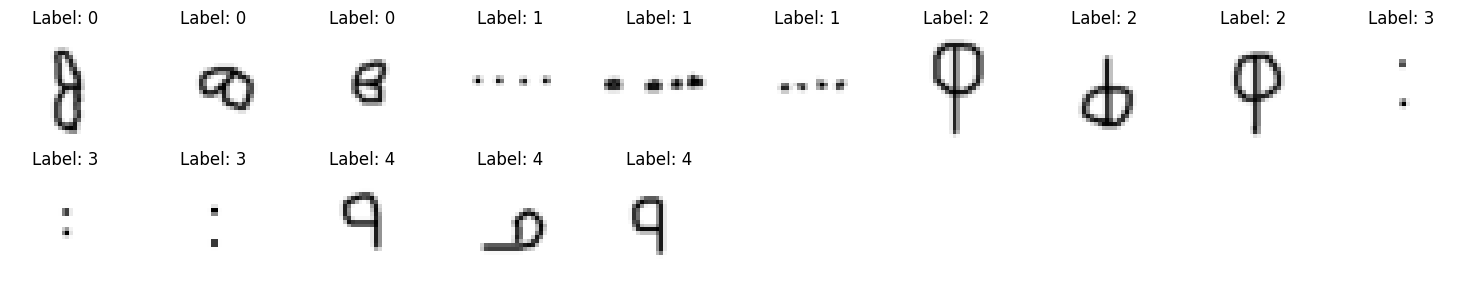


Query Images:


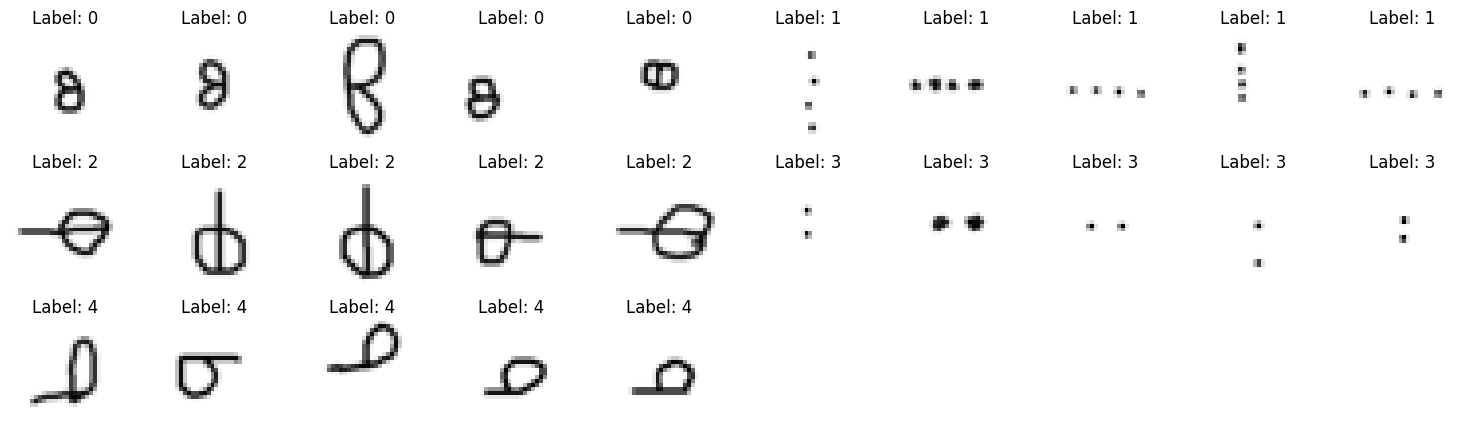

In [17]:
import matplotlib.pyplot as plt
import math

n_way = 5
k_shot = 3
q_query = 5

(support_images, support_labels), (query_images, query_labels) = omniglot_task_sampler(background_dataset, n_way=n_way, k_shot=k_shot, q_query=q_query)

# Display support images
print("Support Images:")
num_support_images = len(support_images)
cols = 10
rows = math.ceil(num_support_images / cols)
fig, axes = plt.subplots(rows, cols, figsize=(cols * 1.5, rows * 1.5))
axes = axes.flatten()

for i in range(num_support_images):
    axes[i].imshow(support_images[i].squeeze(), cmap='gray')
    axes[i].set_title(f'Label: {support_labels[i].item()}')
    axes[i].axis('off')

for j in range(num_support_images, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

# Display query images
print("\nQuery Images:")
num_query_images = len(query_images)
rows = math.ceil(num_query_images / cols)
fig, axes = plt.subplots(rows, cols, figsize=(cols * 1.5, rows * 1.5))
axes = axes.flatten() # Flatten the axes array for easy iteration

for i in range(num_query_images):
    axes[i].imshow(query_images[i].squeeze(), cmap='gray')
    axes[i].set_title(f'Label: {query_labels[i].item()}')
    axes[i].axis('off')

for j in range(num_query_images, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

## Model

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class OmniglotConvNet(nn.Module):
    def __init__(self, n_way):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            nn.Flatten()
        )
        self.classifier = nn.Linear(64 * 1 * 1, n_way)
    def forward(self, x):
        x = self.encoder(x)
        return self.classifier(x)


## MAML Algorithm

As I mentioned, we will run gradients through the optimization steps ( gradient of the gradeint). But PyTorch does not track gradients through optimizer.step() by default. We will use the "higher" library that wraps the model and the optimizer into a functional version

In [19]:
import torch
import torch.nn.functional as F
import higher

def maml_step_full(
    model,
    train_dataset,
    test_dataset,
    n_way=5,
    k_shot=1,
    q_query=1,
    inner_steps=1,
    meta_batch_size=4,
    inner_lr=0.4,
    meta_lr=0.001,
    eval_inner_lr=0.4,
    eval_inner_steps=3,
    device='cuda' if torch.cuda.is_available() else 'cpu'
):
    meta_optimizer = torch.optim.Adam(model.parameters(), lr=meta_lr)
    model.train()
    meta_optimizer.zero_grad()

    meta_train_loss = 0.0
    meta_train_acc = 0.0

    for _ in range(meta_batch_size):
        (support_images, support_labels), (query_images, query_labels) = omniglot_task_sampler(
            train_dataset, n_way, k_shot, q_query
        )
        support_images, support_labels = support_images.to(device), support_labels.to(device)
        query_images, query_labels = query_images.to(device), query_labels.to(device)


        # This creates a differentiable copy of your model (fmodel)
        # and a differentiable optimizer (diffopt) that tracks the update steps
        # as part of the computation graph, allowing backpropagation
        # and clean isolation of task-specific inner loops (copy_initial_weights=False)
        # copy_initial_weights=False = for each task, take the orignal model
        with higher.innerloop_ctx(model, torch.optim.SGD(model.parameters(), lr=inner_lr), copy_initial_weights=False) as (fmodel, diffopt):
            for _ in range(inner_steps):
                support_logits = fmodel(support_images)
                support_loss = F.cross_entropy(support_logits, support_labels)
                diffopt.step(support_loss)

            query_logits = fmodel(query_images)
            task_loss = F.cross_entropy(query_logits, query_labels)
            meta_train_loss += task_loss

            preds = torch.argmax(query_logits, dim=1)
            acc = (preds == query_labels).float().mean().item()
            meta_train_acc += acc

    meta_train_loss /= meta_batch_size # Take the average of all q_tasks losses
    meta_train_acc /= meta_batch_size
    meta_train_loss.backward()
    meta_optimizer.step()

    # ========== Evaluation ========== #
    meta_eval_loss = 0.0
    meta_eval_acc = 0.0

    for _ in range(meta_batch_size):
        (support_images, support_labels), (query_images, query_labels) = omniglot_task_sampler(
            test_dataset, n_way, k_shot, q_query,train=False
        )
        support_images, support_labels = support_images.to(device), support_labels.to(device)
        query_images, query_labels = query_images.to(device), query_labels.to(device)

        # No need for tracking high order gradient since we dont update the meta model
        with higher.innerloop_ctx(model, torch.optim.SGD(model.parameters(), lr=eval_inner_lr), track_higher_grads=False,copy_initial_weights=False) as (fmodel, diffopt):
            for _ in range(eval_inner_steps):
                support_logits = fmodel(support_images)
                support_loss = F.cross_entropy(support_logits, support_labels)
                diffopt.step(support_loss)

            query_logits = fmodel(query_images)
            task_loss = F.cross_entropy(query_logits, query_labels)
            meta_eval_loss += task_loss

            preds = torch.argmax(query_logits, dim=1)
            acc = (preds == query_labels).float().mean().item()
            meta_eval_acc += acc

    meta_eval_loss /= meta_batch_size
    meta_eval_acc /= meta_batch_size

    return {
        "train_loss": meta_train_loss.item(),
        "train_acc": meta_train_acc,
        "eval_loss": meta_eval_loss.item(),
        "eval_acc": meta_eval_acc,
    }


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_steps = 60000
model = OmniglotConvNet(n_way=5).to(device)
for step in range(num_steps):
    stats = maml_step_full(model, background_dataset, evaluation_dataset,q_query=15)
    if step % 10 == 0:
        print(f"step: {step} [Train] Loss: {stats['train_loss']:.4f}, Acc: {stats['train_acc']:.4f} [Eval ] Loss: {stats['eval_loss']:.4f}, Acc: {stats['eval_acc']:.4f}")

step: 0 [Train] Loss: 3.4960, Acc: 0.2000 [Eval ] Loss: 3.3805, Acc: 0.3233
step: 10 [Train] Loss: 1.5187, Acc: 0.3600 [Eval ] Loss: 3.1602, Acc: 0.3700
step: 20 [Train] Loss: 1.3973, Acc: 0.3800 [Eval ] Loss: 2.6275, Acc: 0.3267
step: 30 [Train] Loss: 1.2732, Acc: 0.4600 [Eval ] Loss: 2.5291, Acc: 0.4800
step: 40 [Train] Loss: 1.2482, Acc: 0.4433 [Eval ] Loss: 2.4840, Acc: 0.4233
step: 50 [Train] Loss: 1.1734, Acc: 0.5100 [Eval ] Loss: 1.5497, Acc: 0.5600
step: 60 [Train] Loss: 1.3518, Acc: 0.3667 [Eval ] Loss: 2.0548, Acc: 0.3933
step: 70 [Train] Loss: 1.1688, Acc: 0.4833 [Eval ] Loss: 1.7559, Acc: 0.5133
step: 80 [Train] Loss: 1.2718, Acc: 0.4200 [Eval ] Loss: 1.7724, Acc: 0.6267
step: 90 [Train] Loss: 1.0719, Acc: 0.5633 [Eval ] Loss: 2.5083, Acc: 0.4867
step: 100 [Train] Loss: 0.9095, Acc: 0.5533 [Eval ] Loss: 2.1955, Acc: 0.5167
step: 110 [Train] Loss: 0.9973, Acc: 0.5200 [Eval ] Loss: 2.1605, Acc: 0.5300
step: 120 [Train] Loss: 0.9314, Acc: 0.6267 [Eval ] Loss: 1.7382, Acc: 0.46

# References

[MAML paper](https://arxiv.org/abs/1703.03400)

[Chelsea B. Finn dissertation (Learning to Learn with Gradients)](https://ai.stanford.edu/~cbfinn/_files/dissertation.pdf#page=13.14)

[Meta-Learning in Neural Networks: A Survey
](https://arxiv.org/abs/2004.05439)

